In [24]:
from deep_rl.simple_grid.env import DiscreteGridWorld
from deep_rl.network import *
from deep_rl.utils import *
from sklearn.decomposition import NMF
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 20)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.05 * v)) for v in range(1, 20)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.05 * v)) for v in range(1, 20)],
    *[('green-{}'.format(v), plt.cm.Greens(0.05 * v)) for v in range(1, 20)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.05 * v)) for v in range(1, 20)],
    *[('red-{}'.format(v), plt.cm.Reds(0.05 * v)) for v in range(1, 20)],
])

def imshow(img):
    display(Image.fromarray(np.asarray(img)))

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
drawer = GridDrawer(color_list)

# multitask NMF from: https://ieeexplore.ieee.org/document/6939673
class MTNMF:
    def __init__(self, n_components, l1_ratio=0.0, max_iter=200, tol=0.0001):
        self.n_components = n_components
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol

    def loss(self, X, A, S):
        return 0.5 * ((X - np.matmul(A, S)) ** 2).sum() + self.l1_ratio * S.sum()
        
    # input: a stack of observed data X_1, ..., X_K
    # output: S, A_1, ..., A_K
    def fit(self, X):
        K, N, M = X.shape
        A = np.random.rand(K, N, self.n_components)
        S = np.random.rand(self.n_components, M)
        prev_loss = np.inf
        cur_loss = None
        for i in range(self.max_iter):
            A_T = A.transpose(0, 2, 1)
            new_S = S * (np.matmul(A_T, X).sum(0)) / (np.matmul(np.matmul(A_T, A), S).sum(0) + K * self.l1_ratio * np.ones((self.n_components, M)))
            S = new_S
            new_A = A * np.matmul(X, S.T) / np.matmul(np.matmul(A, S), S.T)
            A = new_A
            cur_loss = self.loss(X, A, S)
            if i % 100 == 0: print('loss:', cur_loss)
            if abs(cur_loss - prev_loss) < self.tol: break
        return A, S, {'loss': cur_loss, 'iter': i}

In [ ]:
# Test MTNMF
X = np.random.rand(10, 300, 400)
A, S, info = MTNMF(20, max_iter=500000).fit(X)
print(A.shape, S.shape, info)

loss: 50596.30248200452
loss: 47183.050079330555
loss: 46624.847221129115
loss: 46411.82125858207
loss: 46295.73268889187
loss: 46222.640539390835
loss: 46172.95030749777
loss: 46136.9957616219
loss: 46109.71161836178
loss: 46088.30171579195
loss: 46070.95957547753
loss: 46056.49317949241
loss: 46044.47302251493
loss: 46034.277495750735
loss: 46025.56246442853
loss: 46018.22330388267
loss: 46011.63857509089
loss: 46005.726946820316
loss: 46000.544167109874
loss: 45996.00625260112
loss: 45991.909966482344
loss: 45988.236922479795
loss: 45984.90763111566
loss: 45981.86092601572
loss: 45979.09559901517
loss: 45976.5876751501
loss: 45974.2393740085
loss: 45972.030255880505
loss: 45970.04149886593
loss: 45968.08051674779
loss: 45966.25505605357
loss: 45964.52762605321
loss: 45962.88043822667
loss: 45961.33801530149
loss: 45959.84225356178
loss: 45958.2707558232
loss: 45956.76065142559
loss: 45955.33404174617
loss: 45954.0173165943
loss: 45952.818846229144
loss: 45951.718060265535
loss: 4595

loss: 45913.06262634131
loss: 45913.02491250362
loss: 45912.99178263438
loss: 45912.96237065512
loss: 45912.93524402689
loss: 45912.906424917324
loss: 45912.87553668455
loss: 45912.84835002391
loss: 45912.823148233445
loss: 45912.79595332338
loss: 45912.765574977755
loss: 45912.736063993
loss: 45912.710129983796
loss: 45912.68796070902
loss: 45912.6662489041
loss: 45912.64002275063
loss: 45912.61594699196
loss: 45912.59424491352
loss: 45912.569770292896
loss: 45912.53730239126
loss: 45912.513148167236
loss: 45912.491673359575
loss: 45912.472115856195
loss: 45912.45471579221
loss: 45912.43768437824
loss: 45912.418691933286
loss: 45912.39939639454
loss: 45912.377617985796
loss: 45912.344473493475
loss: 45912.31554830436
loss: 45912.287727141214
loss: 45912.26289291569
loss: 45912.23583334614
loss: 45912.20688407756
loss: 45912.17843459243
loss: 45912.15098470391
loss: 45912.12892074637
loss: 45912.11108304939
loss: 45912.09432343164
loss: 45912.077084795026
loss: 45912.05981869801
loss: 

loss: 45907.690479016484
loss: 45907.671291744104
loss: 45907.66037739202
loss: 45907.6507341623
loss: 45907.63774744326
loss: 45907.618212287634
loss: 45907.59857574493
loss: 45907.582181819365
loss: 45907.56628304914
loss: 45907.55104839548
loss: 45907.53511145241
loss: 45907.517978054966
loss: 45907.50072163563
loss: 45907.488143903734
loss: 45907.47839678634
loss: 45907.46931394434
loss: 45907.461248992695
loss: 45907.453808226695
loss: 45907.44617579524
loss: 45907.437665420344
loss: 45907.427585939906
loss: 45907.41538521342
loss: 45907.40179859354
loss: 45907.389315879765
loss: 45907.37851476836
loss: 45907.368692824544
loss: 45907.359655307955
loss: 45907.3512425991
loss: 45907.34284386268
loss: 45907.33352079929
loss: 45907.32342444077
loss: 45907.31365863023
loss: 45907.30273130169
loss: 45907.29034375396
loss: 45907.279755337855
loss: 45907.26994613786
loss: 45907.258130097376
loss: 45907.24558734529
loss: 45907.23504486809
loss: 45907.22434839122
loss: 45907.21283068265
los

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 3), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 1), (4, 2), (4, 3), (4, 4), (4, 6), (4, 7), (4, 8), (4, 9), (5, 2), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 8), (7, 1), (7, 2), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 6), (9, 7), (9, 8)]
n_states: 67


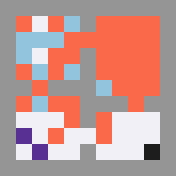

[1 8 8 8 8 7 8 6 1 1 1 1 8 8 9 8 7 3 1 1 1 8 8 8 7 8 1 1 1 1 8 6 9 2 8 3 9
 8 2 2 0 7 8 4 2 2 2 2 2 2 7 4 4 0 2 0 2 0 7 2 4 4 4 2 2 2 2]
{(1, 1): 1, (1, 2): 8, (1, 3): 8, (1, 4): 8, (1, 6): 8, (1, 7): 7, (1, 8): 8, (1, 9): 6, (2, 1): 1, (2, 2): 1, (2, 3): 1, (2, 4): 1, (2, 5): 8, (2, 6): 8, (2, 7): 9, (2, 8): 8, (2, 9): 7, (3, 1): 3, (3, 2): 1, (3, 3): 1, (3, 4): 1, (3, 6): 8, (3, 7): 8, (3, 8): 8, (3, 9): 7, (4, 1): 8, (4, 2): 1, (4, 3): 1, (4, 4): 1, (4, 6): 1, (4, 7): 8, (4, 8): 6, (4, 9): 9, (5, 2): 2, (5, 6): 8, (5, 7): 3, (5, 8): 9, (5, 9): 8, (6, 1): 2, (6, 2): 2, (6, 3): 0, (6, 4): 7, (6, 8): 8, (7, 1): 4, (7, 2): 2, (7, 3): 2, (7, 4): 2, (7, 6): 2, (7, 7): 2, (7, 8): 2, (7, 9): 7, (8, 1): 4, (8, 2): 4, (8, 3): 0, (8, 4): 2, (8, 5): 0, (8, 6): 2, (8, 7): 0, (8, 8): 7, (8, 9): 2, (9, 1): 4, (9, 2): 4, (9, 3): 4, (9, 4): 2, (9, 6): 2, (9, 7): 2, (9, 8): 2}


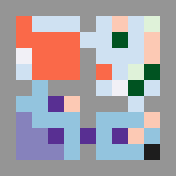

In [17]:
n_abs = 10
state_dim = 2
n_action = 4

visualization_map = dict([
    ('G', 0), # goal
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 100)],
])

def get_states(env):
    # get the whole state space
    states = []
    for i in range(env.size[0]):
        for j in range(env.size[1]):
                if env.is_valid_loc((i, j)):
                    states.append((i, j))
    infos = {'task_id': [0] * len(states)} 
    return states, infos

def get_img(env, abs_list):
    indices = np.zeros(env.size, dtype=np.int64)
    k = 0
    for i in range(env.size[0]):
        for j in range(env.size[1]):
            if (i, j) == env.goal:
                indices[i, j] = 0
            elif env.map[i][j] == '#':
                indices[i, j] = 1
            else:
                indices[i, j] = visualization_map[str(2 + abs_list[k])]
                k += 1

    img = drawer.draw(indices)
    return img

env = DiscreteGridWorld('fourroom', (1, 1), (9, 9))
decomposer = NMF(n_abs, solver='mu', beta_loss='kullback-leibler', random_state=0)

expert = CategoricalActorCriticNet(
    1,
    state_dim,
    n_action,
    FCBody(
        state_dim, 
        hidden_units=(16,)
    ),  
)
# load weight
weight_dict = expert.state_dict()
loaded_weight_dict = {k: v for k, v in torch.load(
    'log/grid.fourroom/fc_discrete.baseline/_/0.190228-203237/models/step-128000-mean-1.00',
    map_location=lambda storage, loc: storage)['network'].items()
    if k in weight_dict}
weight_dict.update(loaded_weight_dict)
expert.load_state_dict(weight_dict)


states, infos = get_states(env)                
print(states)
print('n_states:', len(states))
                
actions = expert(np.array(states), infos)['a'] # maybe take the whole distribution

img = get_img(env, actions.cpu().detach().numpy())
imshow(img)

pvs = F.softmax(expert.get_logits(np.array(states), infos), dim=1).cpu().detach().numpy()
#pvs = one_hot.encode(actions, n_action).cpu().detach().numpy()
abs_mat = decomposer.fit_transform(pvs)
policy_mat = decomposer.components_

abs_list = np.array(abs_mat).argmax(1)
print(abs_list)
abs_map = {s: i for s, i in zip(states, abs_list)}
print(abs_map)
fsave(abs_map, 'data/abs/grid/fourroom/prob.{}'.format(n_abs), 'pkl')

img = get_img(env, abs_list)
imshow(img)